## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install "tf-models-official==2.13.*"

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Replace 'path_to_your_file' with the actual path to your file
df = pd.read_csv('/content/drive/MyDrive/docMed/medical_conversations.csv')

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,data,conversation,patient,doctor
0,This 60-year-old male was hospitalized due to ...,"\nDoctor: Hi, Mr. X, I'm Dr. Y. How are you fe...","\nDoctor Not too good, doctor. I've been feeli...","Hi, Mr. X, I'm Dr. Y. How are you feeling toda..."
1,A 39-year-old man was hospitalized due to an i...,"\nDoctor: Hello, I am Dr. Smith. Can you tell ...","\nDoctor Yes, I have been feeling very weak an...","Hello, I am Dr. Smith. Can you tell me what br..."
2,One week after a positive COVID-19 result this...,"\nDoctor: Good morning, how are you feeling to...","\nDoctor Not so good, doctor. I have been feel...","Good morning, how are you feeling today?\n\nPa..."
3,This 69-year-old male was admitted to the ICU ...,"Doctor: Good morning, sir. How are you feeling...","Doctor Not so good, doctor. I have been feelin...","Good morning, sir. How are you feeling today?\..."
4,This 57-year-old male was admitted to the ICU ...,"\nDoctor: Good morning, Mr. Patient. How are y...","\nDoctor I'm not feeling great, doctor. I have...","Good morning, Mr. Patient. How are you feeling..."


In [7]:
import pandas as pd

# Assuming df is your DataFrame containing 'patient' and 'doctor' columns

# Create an empty list to store the combined conversations and labels
combined_data = []

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Extract patient and doctor conversations from the row
    patient_convo = row['patient']
    doctor_convo = row['doctor']

    # Append patient conversation with label 'patient' to the combined data list
    combined_data.append({'convo': patient_convo, 'label': 'patient'})

    # Append doctor conversation with label 'doctor' to the combined data list
    combined_data.append({'convo': doctor_convo, 'label': 'doctor'})

# Convert the combined data list into a DataFrame
combined_df = pd.DataFrame(combined_data)

# Replace '\n' characters with empty strings in the 'convo' column
combined_df['convo'] = combined_df['convo'].str.replace('\n', '')

# lambda on doctor = 1, patient = 0
combined_df['encode'] = combined_df['label'].apply(lambda x: 1 if x == 'doctor' else 0)

# Display the first few rows of the DataFrame to verify the changes
combined_df.head()

,convo,label,encode
0,"Doctor Not too good, doctor. I've been feeling...",patient,0
1,"Hi, Mr. X, I'm Dr. Y. How are you feeling toda...",doctor,1
2,"Doctor Yes, I have been feeling very weak and ...",patient,0
3,"Hello, I am Dr. Smith. Can you tell me what br...",doctor,1
4,"Doctor Not so good, doctor. I have been feelin...",patient,0


In [8]:
# train-test-split sklearn!
from sklearn.model_selection import train_test_split

# Split the data into train and test sets, maintaining class proportions
X_train, X_test, y_train, y_test = train_test_split(combined_df['convo'], combined_df['encode'], test_size=0.2, stratify=combined_df['encode'], random_state=42)

# Display the shapes of train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (16000,) (16000,)
Test set shape: (4000,) (4000,)


In [9]:
# import BERT model and get embeding vectors for few sample statements

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [10]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [13]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
500/500 [==============================] - 7579s 15s/step - loss: 0.3740 - accuracy: 0.8792 - precision: 0.8752 - recall: 0.8845
Epoch 2/3
500/500 [==============================] - 7443s 15s/step - loss: 0.1591 - accuracy: 0.9747 - precision: 0.9689 - recall: 0.9809
Epoch 3/3
500/500 [==============================] - 7347s 15s/step - loss: 0.1045 - accuracy: 0.9820 - precision: 0.9770 - recall: 0.9872


In [20]:
import keras
# Save the trained model
model.save('docPat_classifier')

# Now you can make predictions using the saved model
# Load the model
loaded_model = keras.models.load_model('docPat_classifier')

# Make predictions on the test set
predictions = loaded_model.predict(X_test)

125/125 [==============================] - 1870s 15s/step


In [29]:
import numpy as np

predictions = np.where(predictions > 0.65, 1, 0)
predictions

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions)
cm

array([[1982,   18],
       [  28, 1972]])

Text(50.722222222222214, 0.5, 'Truth')

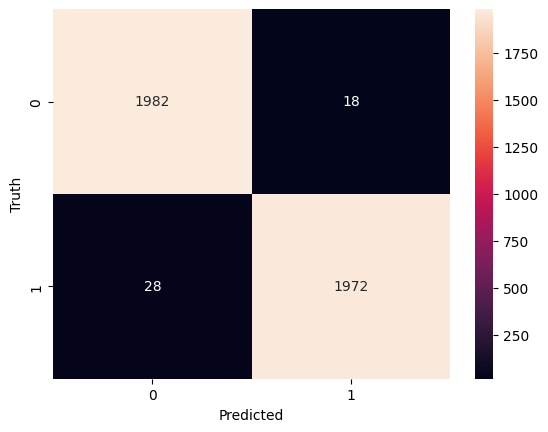

In [31]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2000
           1       0.99      0.99      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [58]:
import numpy as np

# Define the reviews
reviews = [
    'I have severe headache doctor',
    'I understand. Can you tell me what symptoms you\'re experiencing? Patient: Yes, I\'ve been having a fever, a dry cough, and dyspnea. ',
    'These days I couldn\'t sleep doctor',
    'Take 2 pills every day before sleep and visit me after 10 days from today',
    'So I should visit you after 3 days yes doctor',
    'You were hospitalized due to moderate ARDS from COVID-19, is that correct?'
]

# Make predictions
predictions = model.predict(reviews)

# Define a threshold for classification
threshold = 0.4

# Classify each prediction based on the threshold
classified_predictions = ['doctor' if pred > threshold else 'patient' for pred in predictions]

# Print the classified predictions
print(classified_predictions)

1/1 [==============================] - 2s 2s/step
['patient', 'doctor', 'patient', 'doctor', 'patient', 'doctor']


In [42]:
type(reviews)

list

In [45]:
model.save('docMed_Classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
model.save('docMedClassifier.h5')
model.save('dooocMedClassifier')  # The file needs to end with the .keras extension

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
path = '/content/docMedClassifier.h5'
my_reloaded_model = tf.keras.models.load_model(
       (path),
       custom_objects={'KerasLayer':hub.KerasLayer}
)